In [1]:
import imageio
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import gymnasium as gym

In [4]:
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

2023-06-12 12:40:22.089646: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 12:40:22.142712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 12:40:22.964367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import cv2

In [6]:
from gymnasium import spaces

In [7]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.atari_wrappers import StickyActionEnv, NoopResetEnv, MaxAndSkipEnv, EpisodicLifeEnv, FireResetEnv, WarpFrame, ClipRewardEnv

In [8]:
from typing import Any, Callable, Dict, Optional, Type, Union
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecEnv

In [9]:
class UpsideDown(gym.ObservationWrapper[np.ndarray, int, np.ndarray]):
    def __init__(self, env: gym.Env, width: int = 84, height: int = 84) -> None:
        super().__init__(env)
    def observation(self, frame: np.ndarray) -> np.ndarray:
        return np.flipud(frame)

In [10]:
class MyAtariWrapper(gym.Wrapper[np.ndarray, int, np.ndarray, int]):
    """
    Atari 2600 preprocessings

    Specifically:

    * Noop reset: obtain initial state by taking random number of no-ops on reset.
    * Frame skipping: 4 by default
    * Max-pooling: most recent two observations
    * Termination signal when a life is lost.
    * Resize to a square image: 84x84 by default
    * Grayscale observation
    * Clip reward to {-1, 0, 1}
    * Sticky actions: disabled by default

    See https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
    for a visual explanation.

    .. warning::
        Use this wrapper only with Atari v4 without frame skip: ``env_id = "*NoFrameskip-v4"``.

    :param env: Environment to wrap
    :param noop_max: Max number of no-ops
    :param frame_skip: Frequency at which the agent experiences the game.
        This correspond to repeating the action ``frame_skip`` times.
    :param screen_size: Resize Atari frame
    :param terminal_on_life_loss: If True, then step() returns done=True whenever a life is lost.
    :param clip_reward: If True (default), the reward is clip to {-1, 0, 1} depending on its sign.
    :param action_repeat_probability: Probability of repeating the last action
    """

    def __init__(
        self,
        env: gym.Env,
        noop_max: int = 30,
        frame_skip: int = 4,
        screen_size: int = 84,
        terminal_on_life_loss: bool = True,
        clip_reward: bool = True,
        action_repeat_probability: float = 0.0,
    ) -> None:
        if action_repeat_probability > 0.0:
            env = StickyActionEnv(env, action_repeat_probability)
        if noop_max > 0:
            env = NoopResetEnv(env, noop_max=noop_max)
        # frame_skip=1 is the same as no frame-skip (action repeat)
        if frame_skip > 1:
            env = MaxAndSkipEnv(env, skip=frame_skip)
        if terminal_on_life_loss:
            env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():  # type: ignore[attr-defined]
            env = FireResetEnv(env)
        env = WarpFrame(env, width=screen_size, height=screen_size)
        env = UpsideDown(env)
        if clip_reward:
            env = ClipRewardEnv(env)

        super().__init__(env)

In [11]:
def make_my_atari_env(
    env_id: Union[str, Callable[..., gym.Env]],
    n_envs: int = 1,
    seed: Optional[int] = None,
    start_index: int = 0,
    monitor_dir: Optional[str] = None,
    wrapper_kwargs: Optional[Dict[str, Any]] = None,
    env_kwargs: Optional[Dict[str, Any]] = None,
    vec_env_cls: Optional[Union[Type[DummyVecEnv], Type[SubprocVecEnv]]] = None,
    vec_env_kwargs: Optional[Dict[str, Any]] = None,
    monitor_kwargs: Optional[Dict[str, Any]] = None,
    ) -> VecEnv:
    """
    Create a wrapped, monitored VecEnv for Atari.
    It is a wrapper around ``make_vec_env`` that includes common preprocessing for Atari games.

    :param env_id: either the env ID, the env class or a callable returning an env
    :param n_envs: the number of environments you wish to have in parallel
    :param seed: the initial seed for the random number generator
    :param start_index: start rank index
    :param monitor_dir: Path to a folder where the monitor files will be saved.
        If None, no file will be written, however, the env will still be wrapped
        in a Monitor wrapper to provide additional information about training.
    :param wrapper_kwargs: Optional keyword argument to pass to the ``AtariWrapper``
    :param env_kwargs: Optional keyword argument to pass to the env constructor
    :param vec_env_cls: A custom ``VecEnv`` class constructor. Default: None.
    :param vec_env_kwargs: Keyword arguments to pass to the ``VecEnv`` class constructor.
    :param monitor_kwargs: Keyword arguments to pass to the ``Monitor`` class constructor.
    :return: The wrapped environment
    """
    return make_vec_env(
        env_id,
        n_envs=n_envs,
        seed=seed,
        start_index=start_index,
        monitor_dir=monitor_dir,
        wrapper_class=MyAtariWrapper,
        env_kwargs=env_kwargs,
        vec_env_cls=vec_env_cls,
        vec_env_kwargs=vec_env_kwargs,
        monitor_kwargs=monitor_kwargs,
        wrapper_kwargs=wrapper_kwargs,
    )

In [12]:
env_id = "Breakout-v4"
gif_folder = "logfiles/gifs/"
models_folder = "models"

In [13]:
envs = make_my_atari_env(env_id, n_envs=4, seed=0)
envs = VecFrameStack(envs, n_stack=4)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [14]:
obs = envs.reset()
img = envs.render(mode="rgb_array")

/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:364: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


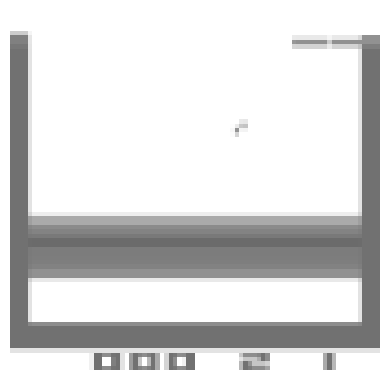

In [15]:
plt.figure(1)
plt.axis(False)
plt.imshow(obs[3,:,:,:])

In [16]:
model = A2C("MlpPolicy", envs, verbose=1)
model.learn(total_timesteps=1E4)
model.save(f"{models_folder}/a2c_upside_vec_{env_id}")

Using cuda device
Wrapping the env in a VecTransposeImage.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 273      |
|    ep_rew_mean        | 1.47     |
| time/                 |          |
|    fps                | 178      |
|    iterations         | 100      |
|    time_elapsed       | 11       |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -1.09    |
|    explained_variance | 0.00382  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.151    |
|    value_loss         | 0.194    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 284      |
|    ep_rew_mean        | 1.74     |
| time/                 |          |
|    fps                | 198      |
|    iterations         | 200      |
|    time_elapsed       | 20       |
|    total_times

In [23]:
env = make_my_atari_env(env_id, n_envs=1, seed=0)
env = VecFrameStack(env, n_stack=4)

In [28]:
images = []
obs = env.reset()
img = env.render(mode="rgb_array")
# for i in range(500):
done = False
# while not done:
for _ in range(500):
    images.append(img)
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    img = env.render(mode="rgb_array")

In [29]:
# fps = 60*4
# dur = len(images)/fps
dur = 30
imageio.mimsave(f"{gif_folder}/{env_id}_upside_vec.gif", [np.array(img) for i, img in enumerate(images) if i%2 == 0], duration=dur)